# Code for Stochatic parameter shift rule

In [1]:
!pip install qiskit
!pip install tqix

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
from qiskit import QuantumCircuit
import qiskit
from tqix import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Pauli matrices # from tqix
sx = sigmax()
sy = sigmay()
sz = sigmaz()
si = eyex(2)
u = obasis(2,0)
d = obasis(2,1)

## Trotter for single paramter

In [4]:
# Define U(x,z)
def uxz(qc,x,z,m):
  qc.h(0) 
  for j in range (m):
    qc.rx(x,0)
    qc.rz(z,0)
  return qc

# Define evolved state
def istate(qc,m,t,theta):
  x = 2*t/m*np.cos(theta)
  z = 2*t/m*np.sin(theta)
  qct = uxz(qc,x,z,m)
  psi = qiskit.quantum_info.Statevector.from_instruction(qct)
  psi = psi.data.reshape((2,1))
  return psi 

# Define derivative
def dev(qc,create_circuit_func,x,z,m,t,theta):
   gradient = []
   x1, z1 = x.copy(), z.copy()
   x1 += np.pi
   z1 += np.pi

   qcx = create_circuit_func(qc.copy(),x1,z,m)
   qcz = create_circuit_func(qc.copy(),x,z1,m)
   dx1 = qiskit.quantum_info.Statevector.from_instruction(qcx).data
   dz1 = qiskit.quantum_info.Statevector.from_instruction(qcz).data
    
   res = -t*np.sin(theta)*dx1 + t*np.cos(theta)*dz1
   return res

In [5]:
# run code 
t = np.linspace(0,np.pi,100)
m = 401
nums = [3,6]


qc = qiskit.QuantumCircuit(1, 1)
create_circuit_func = uxz

for num in nums:
  theta = np.pi/num  
  dat = []  
  for i in t:
    psi = istate(qc.copy(),m,i,theta)
    x = 2*i/m*np.cos(theta)
    z = 2*i/m*np.sin(theta)
    res = dev(qc.copy(),create_circuit_func,x,z,m,i,theta)
    dpsi = res.reshape((2,1))
    gr = 4*(np.dot(dpsi.conj().T,dpsi)-np.dot(dpsi.conj().T,psi)*np.dot(psi.conj().T,dpsi))
    dat.append(np.real(gr[0,0]))
  globals()['qfi_pi%s' % str(num)] = np.real(dat)  
  np.savetxt('qfi_pi%s'%str(num), np.real(dat), delimiter=',')  

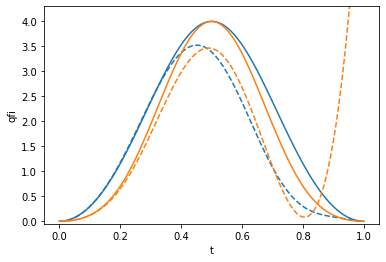

In [6]:
cmap = plt.get_cmap("tab10")

y3 = -4*np.sin(t)**2 * (-1 + np.cos(t)**2 * np.sin(np.pi/3)**2)
y6 = -4*np.sin(t)**2 * (-1 + np.cos(t)**2 * np.sin(np.pi/6)**2)

plt.plot(t/np.pi,y6, 'r',color=cmap(0))
plt.plot(t/np.pi,qfi_pi6, 'r--',color=cmap(0))

plt.plot(t/np.pi,y3, 'g',color=cmap(1))
plt.plot(t/np.pi,qfi_pi3, 'g--',color=cmap(1))

plt.xlabel("t")
plt.ylabel("qfi")
plt.ylim(-0.05,4.3)
plt.show()

## Stoct. PSR

In [7]:
from scipy.linalg import expm
psi0 = 1/np.sqrt(2)*np.array([[1],[1]])
def Ham(theta):
  return np.cos(theta)*sx + np.sin(theta)*sz
def evol(theta,t):
  return expm(-1j*t*Ham(theta))
def psit(theta,t):
  return dotx(evol(theta,t),psi0) 

In [8]:
# para-shift
def shif(theta,t,s,pm):
  dH = np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
  return dotx(evol(theta,s),expm(pm*1j*np.pi/4*dH),evol(theta,(t-s)),psi0)
def der(theta,t,s):
  return shif(theta,t,s,-1) - shif(theta,t,s,1) 

In [9]:
# run the program
Ns = 1000
t = np.linspace(0,np.pi,100)
nums = [3,6]

for num in nums:
    theta = np.pi/num
    dat = []
    for i in t:
      rs = 0.0
      for j in range(Ns):
        s = np.random.uniform(0, i) #np.random.random()*i
        rs += i/(2*np.sin(np.pi/4))*der(theta,i,s) # following Monte-Carlo sampling
      rs /= Ns
      Li01 = dotx(rs.conj().T,rs)
      Li02 = dotx(rs.conj().T,psit(theta,i))
      Li03 = dotx(psit(theta,i).conj().T,rs)
      QLs = 4*np.real((Li01 - Li02*Li03))
      dat.append(QLs[0,0]) 
    globals()['qfi_SPR%s' % str(num)] = np.real(dat)  
    np.savetxt('qfi_SPR%s'%str(num), np.real(dat), delimiter=',')      

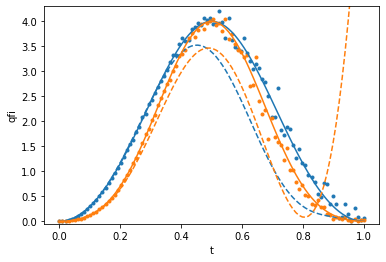

In [10]:
cmap = plt.get_cmap("tab10")

y6 = -4*np.sin(t)**2*(-1 + np.cos(t)**2*np.sin(np.pi/6)**2)
y3 = -4*np.sin(t)**2*(-1 + np.cos(t)**2*np.sin(np.pi/3)**2)

plt.scatter(t/np.pi,qfi_SPR6,marker='.',color=cmap(0))
plt.plot(t/np.pi,y6, 'r',color=cmap(0))
plt.plot(t/np.pi,qfi_pi6, 'r--',color=cmap(0))

plt.scatter(t/np.pi,qfi_SPR3,marker='.',color=cmap(1))
plt.plot(t/np.pi,y3, 'g',color=cmap(1))
plt.plot(t/np.pi,qfi_pi3, 'g--',color=cmap(1))

plt.xlabel("t")
plt.ylabel("qfi")
plt.ylim(-0.05,4.3)
plt.savefig('fig1.eps', format = 'eps', dpi=600)
plt.show()

## Multiparameter

In [11]:
# Define colective Pauli matrices and GHZ state
jx = (tensorx(sx,si,si)+tensorx(si,sx,si)+tensorx(si,si,sx))
jy = (tensorx(sy,si,si)+tensorx(si,sy,si)+tensorx(si,si,sy))
jz = (tensorx(sz,si,si)+tensorx(si,sz,si)+tensorx(si,si,sz))
psi = 1./np.sqrt(2)*(tensorx(u,u,u)+tensorx(d,d,d))

In [12]:
thetas = [np.pi/4,np.pi/4,np.pi/4]
Hami = thetas[0]*jx + thetas[1]*jy +thetas[2]*jz
from scipy.linalg import expm
def Ufunc(t):
  return expm(-1j*t*Hami)
def Psifunc(t):
  # using psi above without call a new one
  return np.dot(Ufunc(t),psi) 

In [11]:
t = np.linspace(0,4,200)
sumtr10 = [] #for theta = pi/10, change this name for diferent thetas
n = 3 # qubits
Ns = 1000
angs = np.pi/50
for i in t:
  [IiX, IiY, IiZ] = [0.0, 0.0, 0.0]
  for j in range(Ns):
    s = np.random.uniform(0, i)
    # get para shift
    xP = dotx(Ufunc(s),expm(-1j*i*angs*jx),Ufunc(i-s),psi)
    xM = dotx(Ufunc(s),expm(1j*i*angs*jx),Ufunc(i-s),psi)
    yP = dotx(Ufunc(s),expm(-1j*i*angs*jy),Ufunc(i-s),psi)
    yM = dotx(Ufunc(s),expm(1j*i*angs*jy),Ufunc(i-s),psi)
    zP = dotx(Ufunc(s),expm(-1j*i*angs*jz),Ufunc(i-s),psi)
    zM = dotx(Ufunc(s),expm(1j*i*angs*jz),Ufunc(i-s),psi)
    # deri
    drX = xP-xM
    drY = yP-yM
    drZ = zP-zM
    # inter
    k = 1/(2*np.sin(i*angs))
    IiX +=  k*drX
    IiY +=  k*drY
    IiZ +=  k*drZ
  #Normalize
  IiXN = i*IiX/Ns
  IiYN = i*IiY/Ns
  IiZN = i*IiZ/Ns
  # state
  sta = Psifunc(i)
  QXX = 4*(np.dot(IiXN.conj().T,IiXN) - np.dot(IiXN.conj().T,sta)*np.dot(sta.conj().T,IiXN))
  QXY = 4*(np.dot(IiXN.conj().T,IiYN) - np.dot(IiXN.conj().T,sta)*np.dot(sta.conj().T,IiYN))
  QXZ = 4*(np.dot(IiXN.conj().T,IiZN) - np.dot(IiXN.conj().T,sta)*np.dot(sta.conj().T,IiZN))
  QYX = 4*(np.dot(IiYN.conj().T,IiXN) - np.dot(IiYN.conj().T,sta)*np.dot(sta.conj().T,IiXN))
  QYY = 4*(np.dot(IiYN.conj().T,IiYN) - np.dot(IiYN.conj().T,sta)*np.dot(sta.conj().T,IiYN))
  QYZ = 4*(np.dot(IiYN.conj().T,IiZN) - np.dot(IiYN.conj().T,sta)*np.dot(sta.conj().T,IiZN))
  QZX = 4*(np.dot(IiZN.conj().T,IiXN) - np.dot(IiZN.conj().T,sta)*np.dot(sta.conj().T,IiXN))
  QZY = 4*(np.dot(IiZN.conj().T,IiYN) - np.dot(IiZN.conj().T,sta)*np.dot(sta.conj().T,IiYN))
  QZZ = 4*(np.dot(IiZN.conj().T,IiZN) - np.dot(IiZN.conj().T,sta)*np.dot(sta.conj().T,IiZN))
  QMs = np.array([[QXX[0,0],QXY[0,0],QXZ[0,0]],[QYX[0,0],QYY[0,0],QYZ[0,0]],[QZX[0,0],QZY[0,0],QZZ[0,0]]])
  QMs = np.real(QMs)
  QMstinv = np.linalg.inv(QMs+10**-10*np.identity(3))
  sumtr10.append(np.trace(QMstinv))  #for theta = pi/10, change this name for diferent thetas

<ipython-input-11-e3645e19c049>:22: RuntimeWarning: divide by zero encountered in double_scalars
  k = 1/(2*np.sin(i*angs))
<ipython-input-11-e3645e19c049>:23: RuntimeWarning: invalid value encountered in multiply
  IiX +=  k*drX
<ipython-input-11-e3645e19c049>:24: RuntimeWarning: invalid value encountered in multiply
  IiY +=  k*drY
<ipython-input-11-e3645e19c049>:25: RuntimeWarning: invalid value encountered in multiply
  IiZ +=  k*drZ


In [ ]:
# for saving file
np.savetxt('data10.out', np.real(sumtr10), delimiter=',')

<ipython-input-49-b10f204a0ec0>:4: RuntimeWarning: divide by zero encountered in true_divide
  y10 = 7/5400. * (50/t**2 + 3*np.pi**2/np.sin(t*np.sqrt(3)/10.*np.pi)**2)
<ipython-input-49-b10f204a0ec0>:5: RuntimeWarning: invalid value encountered in true_divide
  y6 = 7*(6 + np.pi**2*t**2/np.sin(np.pi*t/(2*np.sqrt(3)))**2)/(648*t**2)
<ipython-input-49-b10f204a0ec0>:6: RuntimeWarning: divide by zero encountered in true_divide
  y4 = 7/864.0 * (8/t**2 + 3*np.pi**2/np.sin(np.pi*t*np.sqrt(3)/4.0)**2)


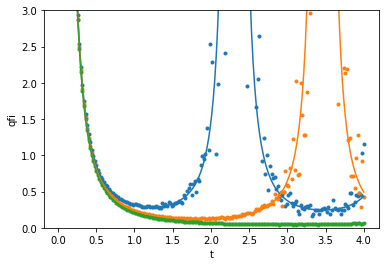

In [49]:
cmap = plt.get_cmap("tab10")

y10 = 7/5400. * (50/t**2 + 3*np.pi**2/np.sin(t*np.sqrt(3)/10.*np.pi)**2)
y6 = 7*(6 + np.pi**2*t**2/np.sin(np.pi*t/(2*np.sqrt(3)))**2)/(648*t**2)
y4 = 7/864.0 * (8/t**2 + 3*np.pi**2/np.sin(np.pi*t*np.sqrt(3)/4.0)**2)

plt.plot(t,y4, color=cmap(0))
plt.scatter(t,sumtr4,marker='.',color=cmap(0))

plt.plot(t,y6, color=cmap(1))
plt.scatter(t,sumtr6,marker='.',color=cmap(1))

plt.plot(t,y10, color=cmap(2))
plt.scatter(t,sumtr10,marker='.',color=cmap(2))

plt.xlabel("t")
plt.ylabel("qfi")
plt.ylim(0,3)
plt.savefig('fig2n.eps', format = 'eps', dpi=600)
plt.show()

In [48]:
# for reading files
sumtr4 = np.loadtxt('data4.out',delimiter=',')
sumtr6 = np.loadtxt('data6.out',delimiter=',')
sumtr10 = np.loadtxt('data10.out',delimiter=',')
